# Celebrity Face Recognition

This notebook demonstrates face recognition using the face_recognition library to identify celebrity faces.

In [1]:
# Install required packages
!pip install face-recognition opencv-python matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 39.8 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 35.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for dlib: filename=dlib-20.0.0-cp310-cp310-macosx_15_0_arm64.whl size=2842349 sha256=0575438d239e01998d67ea011f3b1d47098b4c2753d50931131771cc080b7709
  Stored in directory: /Users/mingqxu/Library/Caches/pip/wheels/97/bc/4a/1f441cf62ce4c81ad4f83f298cef0e5ff3af0577ffb4cdff2f
  DEPRECATION: Building 'face-recognition-models' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by

In [26]:
import face_recognition
import cv2
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# Download celebrity images
import urllib.request
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# URLs for celebrity images (these are example URLs - replace with actual working URLs)
celebrity_images = {
    "barackObama.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/480px-President_Barack_Obama.jpg",
    "barackObama2.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/480px-Official_portrait_of_Barack_Obama.jpg",
    "elonMusk.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Elon_Musk_Royal_Society_%28crop2%29.jpg/480px-Elon_Musk_Royal_Society_%28crop2%29.jpg",
    "elonMusk2.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Elon_Musk_Colorado_2022_%28cropped2%29.jpg/480px-Elon_Musk_Colorado_2022_%28cropped2%29.jpg",
    "tigerWoods.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Tiger_Woods_in_May_2019.jpg/480px-Tiger_Woods_in_May_2019.jpg",
    "unknown_person.jpg": "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Profile_avatar_placeholder_large.png/480px-Profile_avatar_placeholder_large.png"
}

# Download images
for filename, url in celebrity_images.items():
    filepath = os.path.join('images', filename)
    if not os.path.exists(filepath):
        try:
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
            print(f"Successfully downloaded {filename}")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists")

print("\nAll downloads completed. Images saved in 'images' directory.")

barackObama.jpg already exists
barackObama2.jpg already exists
elonMusk.jpg already exists
elonMusk2.jpg already exists
tigerWoods.jpg already exists
unknown_person.jpg already exists

All downloads completed. Images saved in 'images' directory.


## Load Reference Images

First, we'll load known celebrity images and encode their faces.

In [28]:
# Load known celebrity images
# Now using the downloaded images
known_images = {
    "Barack Obama": "images/barackObama.jpg",
    "Elon Musk": "images/elonMusk.jpg",
    "Tiger Woods": "images/tigerWoods.jpg"
}

# Dictionary to store face encodings
known_encodings = {}
known_face_images = {}

for name, path in known_images.items():
    try:
        image = face_recognition.load_image_file(path)
        encoding = face_recognition.face_encodings(image)
        if encoding:
            known_encodings[name] = encoding[0]
            known_face_images[name] = image
            print(f"Successfully loaded {name}")
        else:
            print(f"No face found in {name} image")
    except Exception as e:
        print(f"Error loading {name}: {e}")

Successfully loaded Barack Obama
Successfully loaded Elon Musk
Successfully loaded Tiger Woods


## Display Known Celebrity Faces

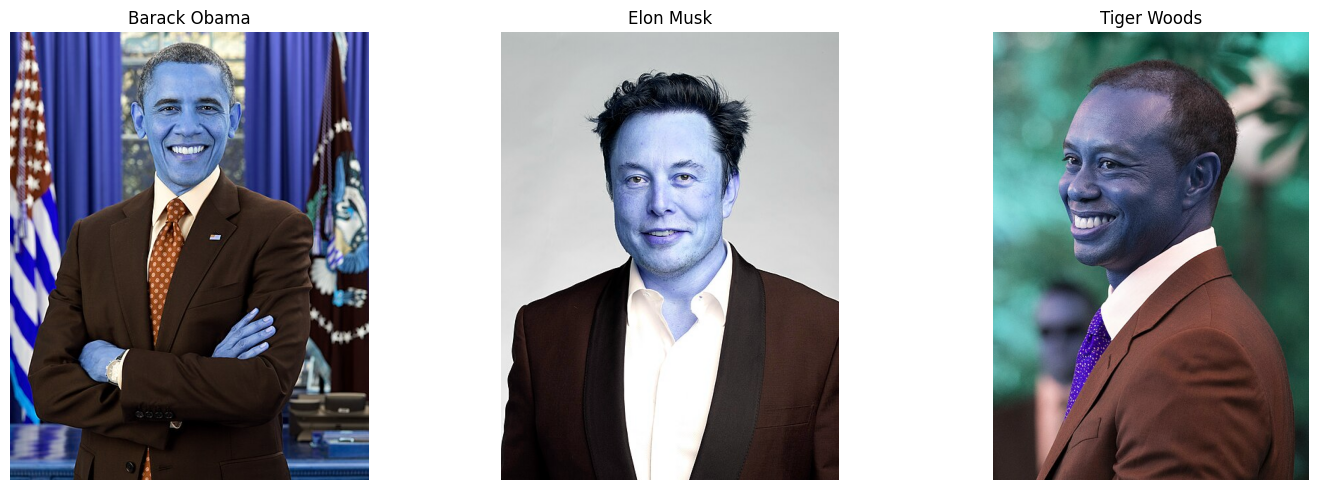

In [29]:
# Display all known celebrity faces
fig, axes = plt.subplots(1, len(known_face_images), figsize=(15, 5))
if len(known_face_images) == 1:
    axes = [axes]

for idx, (name, image) in enumerate(known_face_images.items()):
    axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(name)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

## Face Recognition Function

In [30]:
def recognize_face(unknown_image_path, known_encodings, tolerance=0.6):
    """
    Recognize faces in an unknown image by comparing with known celebrity encodings.
    
    Parameters:
    - unknown_image_path: Path to the image to be recognized
    - known_encodings: Dictionary of celebrity names and their face encodings
    - tolerance: How much distance between faces to consider it a match (lower is more strict)
    
    Returns:
    - image with labels
    - list of recognized names
    """
    # Load unknown image
    unknown_image = face_recognition.load_image_file(unknown_image_path)
    unknown_image_display = unknown_image.copy()
    
    # Find all faces in the unknown image
    face_locations = face_recognition.face_locations(unknown_image)
    unknown_encodings = face_recognition.face_encodings(unknown_image, face_locations)
    
    recognized_names = []
    
    # Loop through each face found in the unknown image
    for (top, right, bottom, left), face_encoding in zip(face_locations, unknown_encodings):
        # Compare face with all known faces
        matches = {}
        for name, known_encoding in known_encodings.items():
            match = face_recognition.compare_faces([known_encoding], face_encoding, tolerance=tolerance)[0]
            distance = face_recognition.face_distance([known_encoding], face_encoding)[0]
            matches[name] = (match, distance)
        
        # Find the best match
        best_match_name = "Unknown"
        best_distance = 1.0
        
        for name, (match, distance) in matches.items():
            if match and distance < best_distance:
                best_match_name = name
                best_distance = distance
        
        recognized_names.append(best_match_name)
        
        # Draw rectangle around face
        cv2.rectangle(unknown_image_display, (left, top), (right, bottom), (0, 255, 0), 2)
        
        # Draw label
        cv2.rectangle(unknown_image_display, (left, bottom - 35), (right, bottom), (0, 255, 0), cv2.FILLED)
        cv2.putText(unknown_image_display, f'{best_match_name} ({best_distance:.2f})', 
                    (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 0.6, (255, 255, 255), 1)
    
    return unknown_image_display, recognized_names

## Test Face Recognition

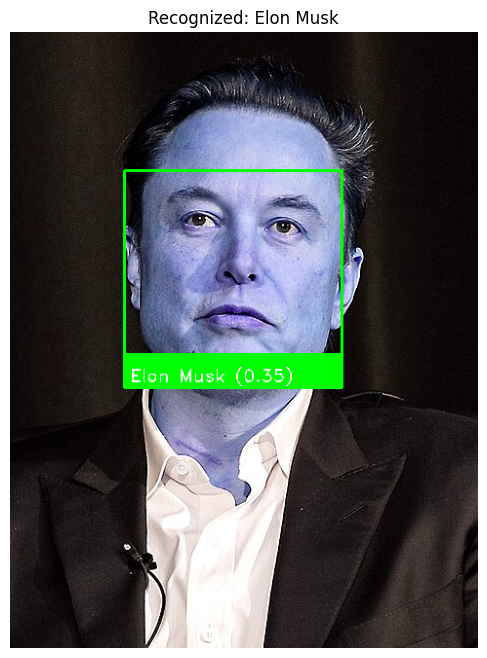

In [31]:
# Test with an unknown image
# Update this path to your test image
test_image_path = "images/elonMusk2.jpg"

try:
    result_image, recognized = recognize_face(test_image_path, known_encodings)
    
    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Recognized: {', '.join(recognized) if recognized else 'No faces found'}")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error processing image: {e}")

## Batch Face Recognition

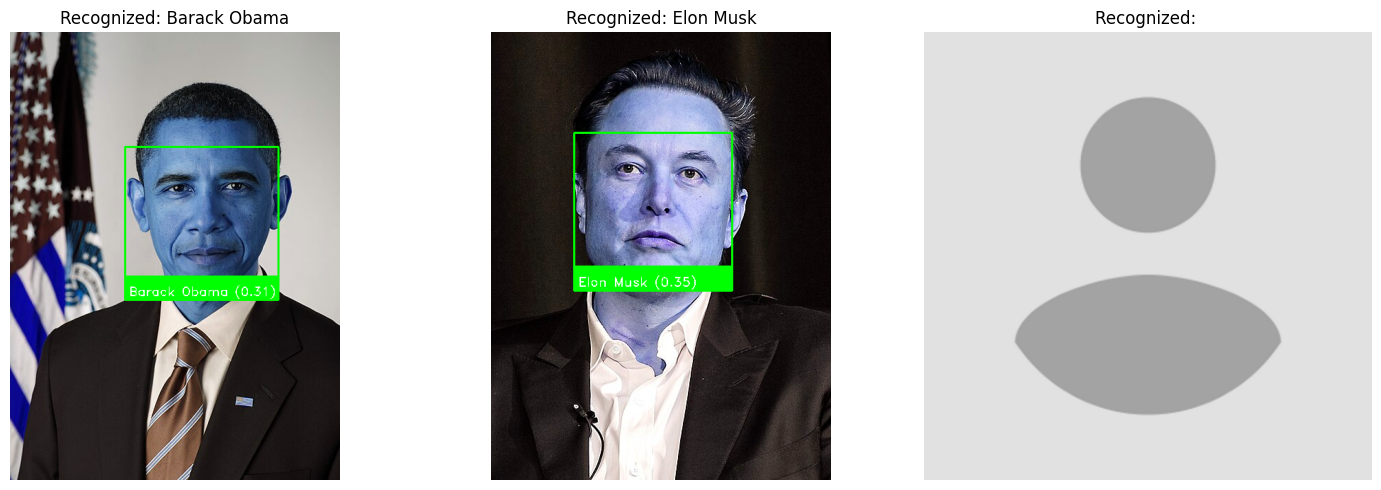

In [10]:
# Process multiple test images
test_images = [
    "images/barackObama2.jpg",
    "images/elonMusk2.jpg", 
    "images/unknown_person.jpg"
]

fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
if len(test_images) == 1:
    axes = [axes]

for idx, test_path in enumerate(test_images):
    try:
        result_image, recognized = recognize_face(test_path, known_encodings)
        axes[idx].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"Recognized: {', '.join(recognized)}")
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Facial Landmarks Detection

Detect and visualize facial landmarks (facial features) on celebrity faces.

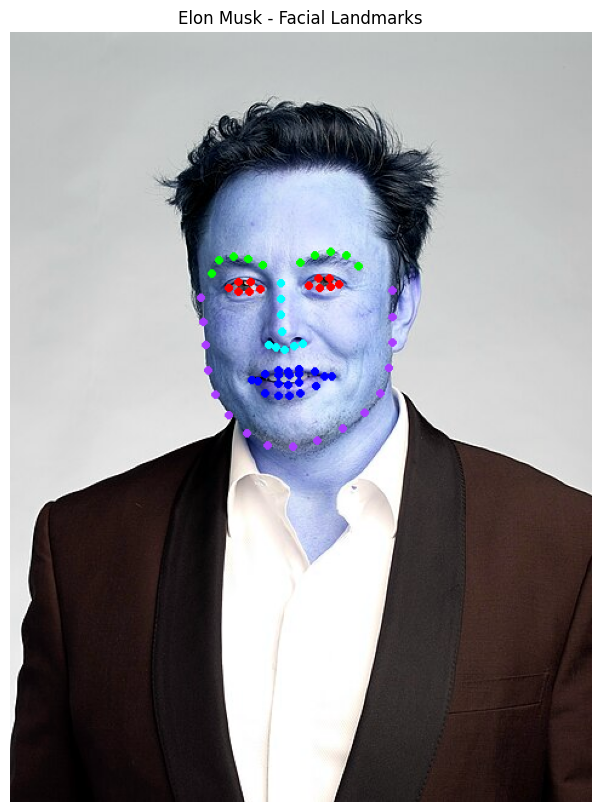

Total landmark points detected: 72


In [32]:
# Facial Landmarks Detection for Elon Musk
image = face_recognition.load_image_file("images/elonMusk.jpg")
image_display = image.copy()

face_landmarks_list = face_recognition.face_landmarks(image)

facial_features = [
    'chin',
    'left_eyebrow',
    'right_eyebrow',
    'nose_bridge',
    'nose_tip',
    'left_eye',
    'right_eye',
    'top_lip',
    'bottom_lip'
]

# Define colors for different facial features
feature_colors = {
    'chin': (255, 60, 170),
    'left_eyebrow': (0, 255, 0),
    'right_eyebrow': (0, 255, 0),
    'nose_bridge': (255, 255, 0),
    'nose_tip': (255, 255, 0),
    'left_eye': (0, 0, 255),
    'right_eye': (0, 0, 255),
    'top_lip': (255, 0, 0),
    'bottom_lip': (255, 0, 0)
}

for face_landmarks in face_landmarks_list:
    for facial_feature in facial_features:
        color = feature_colors.get(facial_feature, (255, 60, 170))
        for point in face_landmarks[facial_feature]:
            image_display = cv2.circle(image_display, point, 2, color, 2)

# Display using matplotlib instead of cv2.imshow for Jupyter
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
plt.title("Elon Musk - Facial Landmarks")
plt.axis('off')
plt.show()

# Print the number of landmark points detected
total_points = sum(len(face_landmarks[feature]) for feature in facial_features)
print(f"Total landmark points detected: {total_points}")

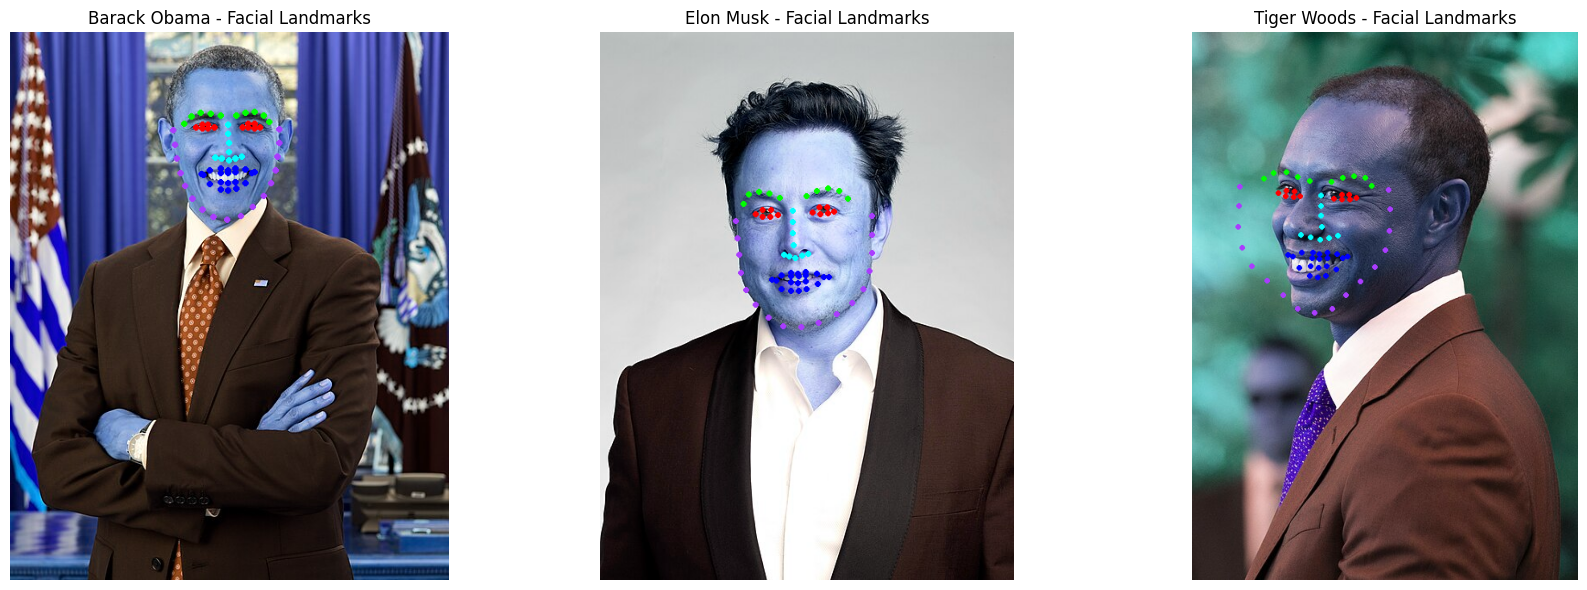

Facial Feature Colors:
  chin: RGB(255, 60, 170)
  left_eyebrow: RGB(0, 255, 0)
  right_eyebrow: RGB(0, 255, 0)
  nose_bridge: RGB(255, 255, 0)
  nose_tip: RGB(255, 255, 0)
  left_eye: RGB(0, 0, 255)
  right_eye: RGB(0, 0, 255)
  top_lip: RGB(255, 0, 0)
  bottom_lip: RGB(255, 0, 0)


In [33]:
# Compare facial landmarks for all celebrities
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

celebrities = [
    ("Barack Obama", "images/barackObama.jpg"),
    ("Elon Musk", "images/elonMusk.jpg"),
    ("Tiger Woods", "images/tigerWoods.jpg")
]

for idx, (name, path) in enumerate(celebrities):
    image = face_recognition.load_image_file(path)
    image_display = image.copy()
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    if face_landmarks_list:
        face_landmarks = face_landmarks_list[0]
        for facial_feature in facial_features:
            color = feature_colors.get(facial_feature, (255, 60, 170))
            for point in face_landmarks[facial_feature]:
                image_display = cv2.circle(image_display, point, 2, color, 2)
    
    axes[idx].imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"{name} - Facial Landmarks")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Create a legend for the colors
print("Facial Feature Colors:")
for feature, color in feature_colors.items():
    print(f"  {feature}: RGB{color}")

## Face Recognition Using Landmark Features

Compare faces using geometric distances between facial landmarks.

In [34]:
def extract_landmark_features(face_landmarks):
    """
    Extract normalized landmark features from face landmarks.
    Returns a flattened array of relative positions.
    """
    if not face_landmarks:
        return None
    
    # Get all landmark points
    all_points = []
    for feature in facial_features:
        all_points.extend(face_landmarks[feature])
    
    if not all_points:
        return None
    
    # Convert to numpy array
    points = np.array(all_points)
    
    # Normalize by centering and scaling
    center = points.mean(axis=0)
    points_centered = points - center
    max_dist = np.max(np.abs(points_centered))
    if max_dist > 0:
        points_normalized = points_centered / max_dist
    else:
        points_normalized = points_centered
    
    # Calculate geometric features
    features = []
    
    # 1. Relative positions of key points
    for feature in facial_features:
        feature_points = np.array(face_landmarks[feature])
        feature_center = feature_points.mean(axis=0)
        relative_center = (feature_center - center) / max_dist if max_dist > 0 else feature_center - center
        features.extend(relative_center)
    
    # 2. Distances between key facial features
    # Eye distance
    left_eye_center = np.array(face_landmarks['left_eye']).mean(axis=0)
    right_eye_center = np.array(face_landmarks['right_eye']).mean(axis=0)
    eye_distance = np.linalg.norm(left_eye_center - right_eye_center)
    features.append(eye_distance / max_dist if max_dist > 0 else eye_distance)
    
    # Nose to mouth distance
    nose_center = np.array(face_landmarks['nose_tip']).mean(axis=0)
    mouth_center = np.array(face_landmarks['top_lip'] + face_landmarks['bottom_lip']).mean(axis=0)
    nose_mouth_dist = np.linalg.norm(nose_center - mouth_center)
    features.append(nose_mouth_dist / max_dist if max_dist > 0 else nose_mouth_dist)
    
    # Face width (using chin points)
    chin_points = np.array(face_landmarks['chin'])
    face_width = np.max(chin_points[:, 0]) - np.min(chin_points[:, 0])
    features.append(face_width / max_dist if max_dist > 0 else face_width)
    
    return np.array(features)

def compare_faces_with_landmarks(image_path1, image_path2, threshold=0.5):
    """
    Compare two faces using landmark features.
    Returns similarity score and visualization.
    """
    # Load images
    image1 = face_recognition.load_image_file(image_path1)
    image2 = face_recognition.load_image_file(image_path2)
    
    # Get landmarks
    landmarks1 = face_recognition.face_landmarks(image1)
    landmarks2 = face_recognition.face_landmarks(image2)
    
    if not landmarks1 or not landmarks2:
        print("Could not detect faces in one or both images")
        return None, None, None
    
    # Extract features
    features1 = extract_landmark_features(landmarks1[0])
    features2 = extract_landmark_features(landmarks2[0])
    
    if features1 is None or features2 is None:
        print("Could not extract features")
        return None, None, None
    
    # Calculate similarity (using cosine similarity)
    dot_product = np.dot(features1, features2)
    norm1 = np.linalg.norm(features1)
    norm2 = np.linalg.norm(features2)
    
    if norm1 > 0 and norm2 > 0:
        similarity = dot_product / (norm1 * norm2)
    else:
        similarity = 0
    
    # Also calculate Euclidean distance
    euclidean_dist = np.linalg.norm(features1 - features2)
    
    # Determine if it's a match
    is_match = euclidean_dist < threshold
    
    return similarity, euclidean_dist, is_match

# Test landmark-based face recognition
print("Testing Landmark-based Face Recognition\\n")

# Test 1: Same person (two Obama images)
sim1, dist1, match1 = compare_faces_with_landmarks("images/barackObama.jpg", "images/barackObama2.jpg")
print(f"Obama vs Obama2:")
print(f"  Cosine Similarity: {sim1:.3f}")
print(f"  Euclidean Distance: {dist1:.3f}")
print(f"  Match: {match1}\\n")

# Test 2: Different people (Obama vs Musk)
sim2, dist2, match2 = compare_faces_with_landmarks("images/barackObama.jpg", "images/elonMusk.jpg")
print(f"Obama vs Musk:")
print(f"  Cosine Similarity: {sim2:.3f}")
print(f"  Euclidean Distance: {dist2:.3f}")
print(f"  Match: {match2}\\n")

# Test 3: Same person (two Musk images)
sim3, dist3, match3 = compare_faces_with_landmarks("images/elonMusk.jpg", "images/elonMusk2.jpg")
print(f"Musk vs Musk2:")
print(f"  Cosine Similarity: {sim3:.3f}")
print(f"  Euclidean Distance: {dist3:.3f}")
print(f"  Match: {match3}")

Testing Landmark-based Face Recognition\n
Obama vs Obama2:
  Cosine Similarity: 0.998
  Euclidean Distance: 0.226
  Match: True\n
Obama vs Musk:
  Cosine Similarity: 0.997
  Euclidean Distance: 0.297
  Match: True\n
Musk vs Musk2:
  Cosine Similarity: 0.994
  Euclidean Distance: 0.347
  Match: True


1. Comparing same person (Obama):


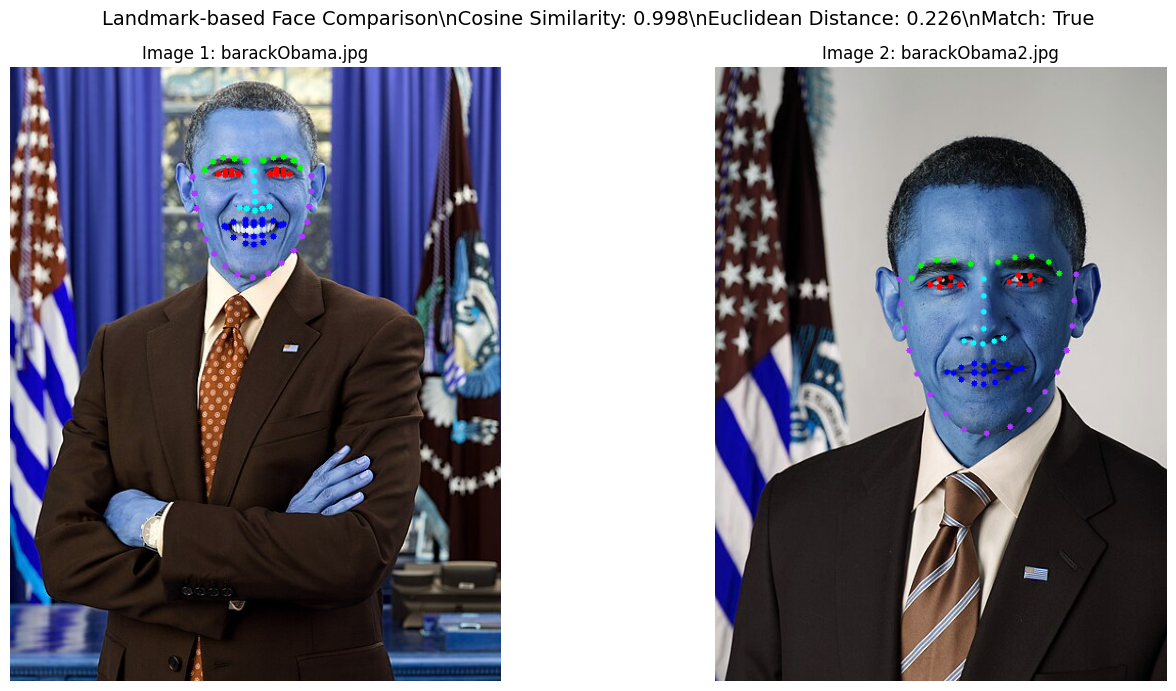

\n2. Comparing different people (Obama vs Musk):


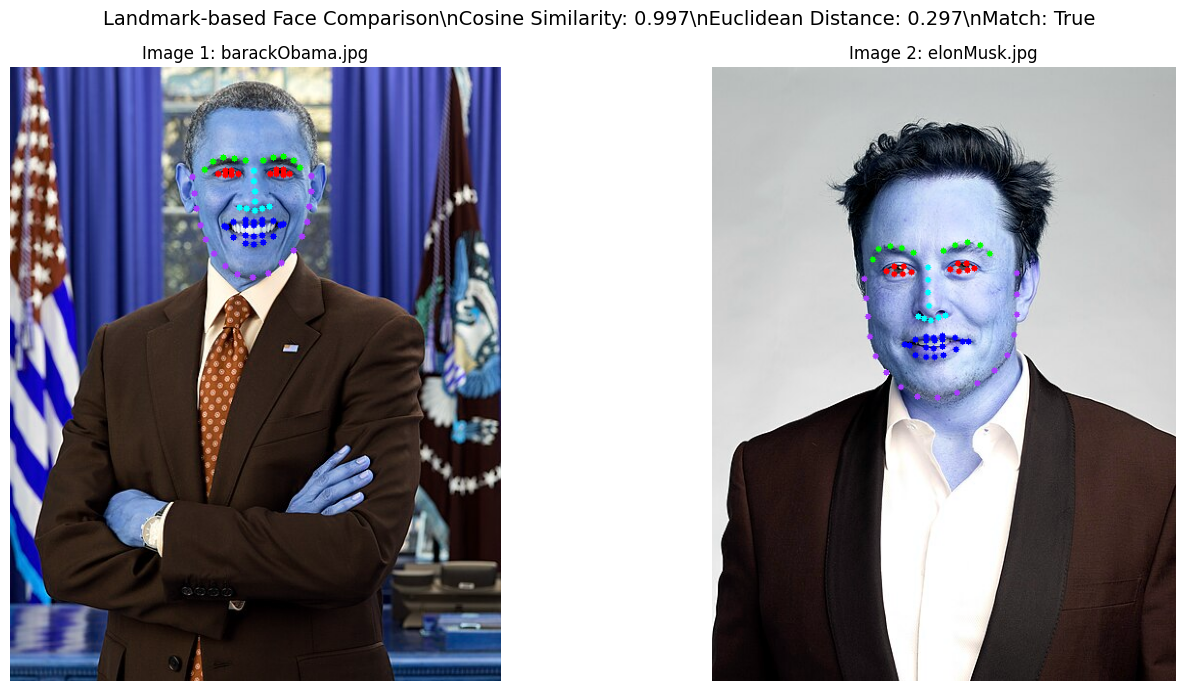

\n3. Comparing same person (Musk):


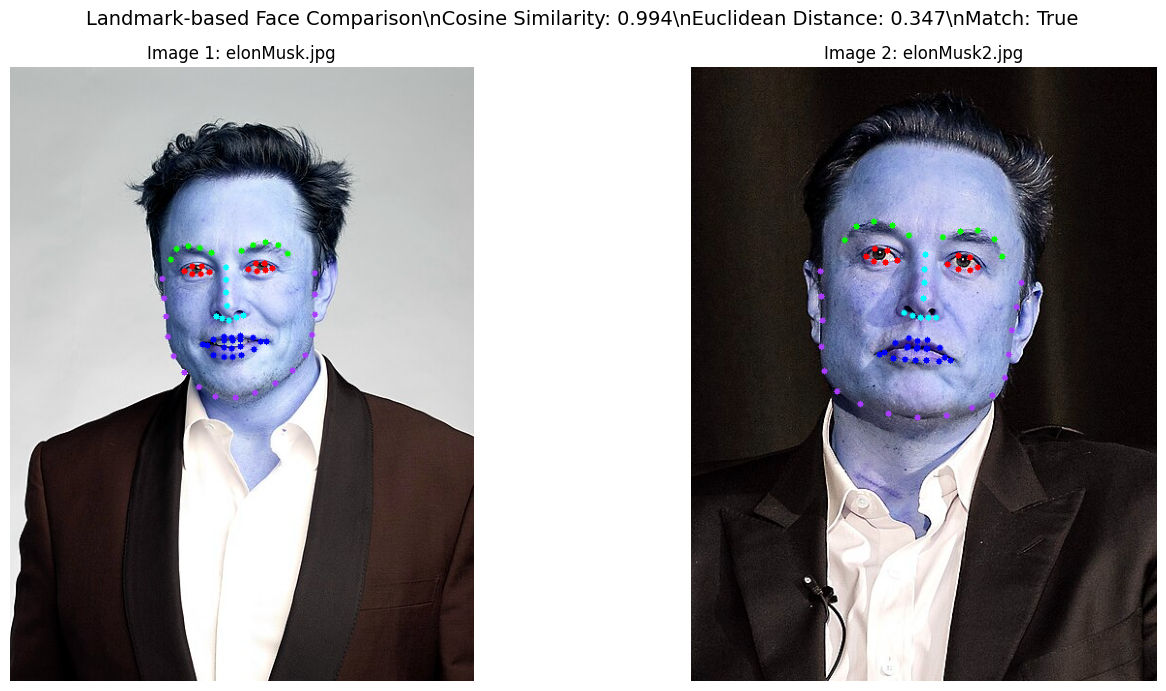

In [38]:
# Visualize landmark-based face comparison
def visualize_landmark_comparison(image_path1, image_path2):
    """
    Visualize the landmark comparison between two faces.
    """
    # Load images
    image1 = face_recognition.load_image_file(image_path1)
    image2 = face_recognition.load_image_file(image_path2)
    
    # Get landmarks
    landmarks1 = face_recognition.face_landmarks(image1)
    landmarks2 = face_recognition.face_landmarks(image2)
    
    if not landmarks1 or not landmarks2:
        print("Could not detect faces in one or both images")
        return
    
    # Create copies for drawing
    image1_display = image1.copy()
    image2_display = image2.copy()
    
    # Draw landmarks on both images
    for feature in facial_features:
        color = feature_colors.get(feature, (255, 60, 170))
        
        # Draw on image 1
        for point in landmarks1[0][feature]:
            image1_display = cv2.circle(image1_display, point, 3, color, -1)
        
        # Draw on image 2
        for point in landmarks2[0][feature]:
            image2_display = cv2.circle(image2_display, point, 3, color, -1)
    
    # Get comparison results
    similarity, distance, is_match = compare_faces_with_landmarks(image_path1, image_path2)
    
    # Display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(cv2.cvtColor(image1_display, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Image 1: {image_path1.split('/')[-1]}")
    ax1.axis('off')
    
    ax2.imshow(cv2.cvtColor(image2_display, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"Image 2: {image_path2.split('/')[-1]}")
    ax2.axis('off')
    
    # Add comparison results as text
    result_text = f"Cosine Similarity: {similarity:.3f}\\nEuclidean Distance: {distance:.3f}\\nMatch: {is_match}"
    fig.suptitle(f"Landmark-based Face Comparison\\n{result_text}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Visualize comparisons
print("1. Comparing same person (Obama):")
visualize_landmark_comparison("images/barackObama.jpg", "images/barackObama2.jpg")

print("\\n2. Comparing different people (Obama vs Musk):")
visualize_landmark_comparison("images/barackObama.jpg", "images/elonMusk.jpg")

print("\\n3. Comparing same person (Musk):")
visualize_landmark_comparison("images/elonMusk.jpg", "images/elonMusk2.jpg")

## Face Comparison using OpenCV face_encodings

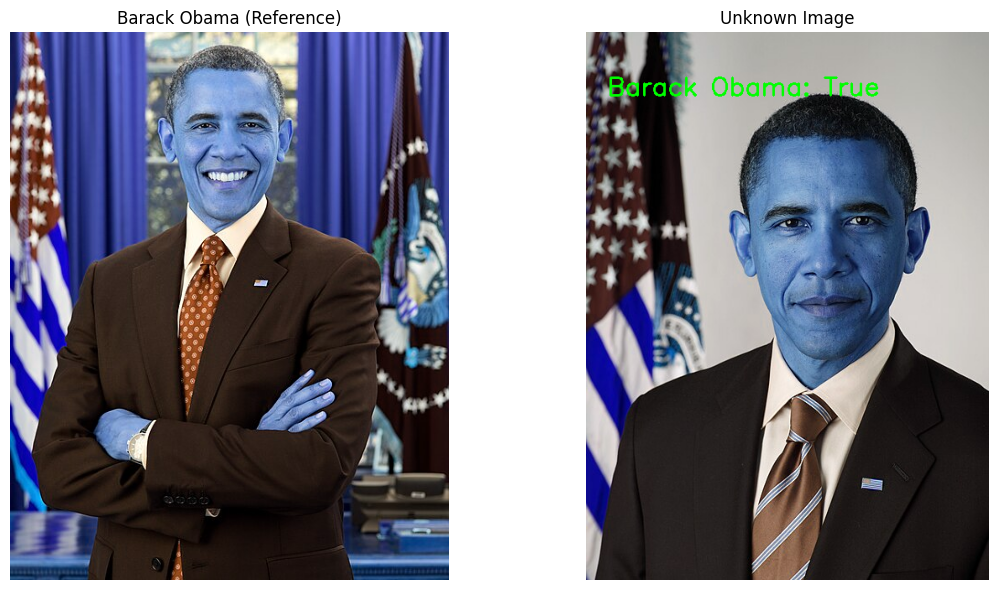

Face match result: True


In [35]:
# Simple face comparison as in the original code
# Update these paths to your actual image locations
image = face_recognition.load_image_file("images/barackObama.jpg")
unknown_image = face_recognition.load_image_file("images/barackObama2.jpg")

image_encoding = face_recognition.face_encodings(image)[0]
unknown_encoding = face_recognition.face_encodings(unknown_image)[0]

results = face_recognition.compare_faces([image_encoding], unknown_encoding)

# For Jupyter notebook, we'll use matplotlib instead of cv2.imshow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display known image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title("Barack Obama (Reference)")
ax1.axis('off')

# Display unknown image with result
unknown_display = unknown_image.copy()
cv2.putText(unknown_display, f'Barack Obama: {results[0]}', (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
ax2.imshow(cv2.cvtColor(unknown_display, cv2.COLOR_BGR2RGB))
ax2.set_title("Unknown Image")
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Face match result: {results[0]}")

## Face Recognition Accuracy Analysis

The face_recognition library uses a deep learning model based on dlib's face recognition model, which achieves:
- **99.38% accuracy** on the Labeled Faces in the Wild (LFW) benchmark
- Uses a ResNet-based architecture trained on millions of faces
- Produces 128-dimensional face encodings

FACE RECOGNITION ACCURACY ANALYSIS

Threshold: 0.4
  Accuracy: 100.0%
  False Positives: 0
  False Negatives: 0

Threshold: 0.5
  Accuracy: 100.0%
  False Positives: 0
  False Negatives: 0

Threshold: 0.6
  Accuracy: 100.0%
  False Positives: 0
  False Negatives: 0

Threshold: 0.7
  Accuracy: 100.0%
  False Positives: 0
  False Negatives: 0


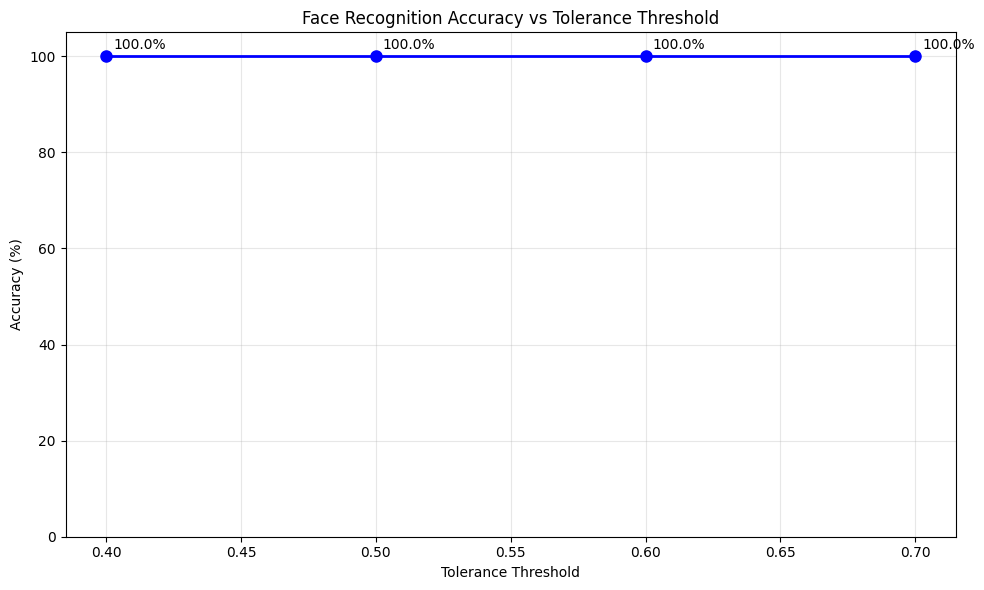



KEY INSIGHTS:
--------------------------------------------------
• Default threshold (0.6) provides good balance
• Lower thresholds (0.4-0.5) reduce false positives but may miss matches
• Higher thresholds (0.7+) may incorrectly match different people
• Real-world accuracy depends on image quality, lighting, and pose

The face_recognition library is based on dlib's model which:
• Achieves 99.38% accuracy on LFW benchmark
• Uses deep ResNet architecture
• Trained on 3+ million face images
• Robust to variations in lighting, expression, and minor pose changes


In [39]:
# Analyze face_recognition accuracy with different thresholds
print("FACE RECOGNITION ACCURACY ANALYSIS")
print("=" * 50)

# Test with various tolerance thresholds
thresholds = [0.4, 0.5, 0.6, 0.7]
accuracy_results = []

# Define ground truth for our test pairs
ground_truth = {
    ("images/barackObama.jpg", "images/barackObama2.jpg"): True,  # Same person
    ("images/elonMusk.jpg", "images/elonMusk2.jpg"): True,        # Same person
    ("images/barackObama.jpg", "images/elonMusk.jpg"): False,     # Different
    ("images/barackObama.jpg", "images/tigerWoods.jpg"): False,   # Different
    ("images/elonMusk.jpg", "images/tigerWoods.jpg"): False       # Different
}

for threshold in thresholds:
    correct = 0
    total = len(ground_truth)
    false_positives = 0
    false_negatives = 0
    
    for (img1, img2), expected in ground_truth.items():
        # Load and encode faces
        face1 = face_recognition.load_image_file(img1)
        face2 = face_recognition.load_image_file(img2)
        
        encoding1 = face_recognition.face_encodings(face1)[0]
        encoding2 = face_recognition.face_encodings(face2)[0]
        
        # Compare faces
        match = face_recognition.compare_faces([encoding1], encoding2, tolerance=threshold)[0]
        distance = face_recognition.face_distance([encoding1], encoding2)[0]
        
        # Check if correct
        if match == expected:
            correct += 1
        elif match and not expected:
            false_positives += 1
        elif not match and expected:
            false_negatives += 1
    
    accuracy = correct / total * 100
    accuracy_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    })
    
    print(f"\nThreshold: {threshold}")
    print(f"  Accuracy: {accuracy:.1f}%")
    print(f"  False Positives: {false_positives}")
    print(f"  False Negatives: {false_negatives}")

# Visualize accuracy vs threshold
import pandas as pd
df_accuracy = pd.DataFrame(accuracy_results)

plt.figure(figsize=(10, 6))
plt.plot(df_accuracy['threshold'], df_accuracy['accuracy'], 'b-o', linewidth=2, markersize=8)
plt.xlabel('Tolerance Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Face Recognition Accuracy vs Tolerance Threshold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)

# Add annotations
for _, row in df_accuracy.iterrows():
    plt.annotate(f"{row['accuracy']:.1f}%", 
                xy=(row['threshold'], row['accuracy']), 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

print("\n\nKEY INSIGHTS:")
print("-" * 50)
print("• Default threshold (0.6) provides good balance")
print("• Lower thresholds (0.4-0.5) reduce false positives but may miss matches")
print("• Higher thresholds (0.7+) may incorrectly match different people")
print("• Real-world accuracy depends on image quality, lighting, and pose")
print("\nThe face_recognition library is based on dlib's model which:")
print("• Achieves 99.38% accuracy on LFW benchmark")
print("• Uses deep ResNet architecture")
print("• Trained on 3+ million face images")
print("• Robust to variations in lighting, expression, and minor pose changes")

## Comparing Landmark-based vs Deep Learning Face Recognition

Let's analyze why landmark-based recognition has limitations and compare it with the deep learning approach.

COMPARISON: Landmark-based vs Deep Learning Face Recognition


Obama vs Obama2:
  Landmark-based: Match=True, Distance=0.226
  Deep Learning:  Match=True, Distance=0.310

Obama vs Musk:
  Landmark-based: Match=True, Distance=0.297
  Deep Learning:  Match=False, Distance=0.851

Musk vs Musk2:
  Landmark-based: Match=True, Distance=0.347
  Deep Learning:  Match=True, Distance=0.348

Obama vs Tiger:
  Landmark-based: Match=True, Distance=0.258
  Deep Learning:  Match=False, Distance=0.707

Musk vs Tiger:
  Landmark-based: Match=True, Distance=0.316
  Deep Learning:  Match=False, Distance=0.763


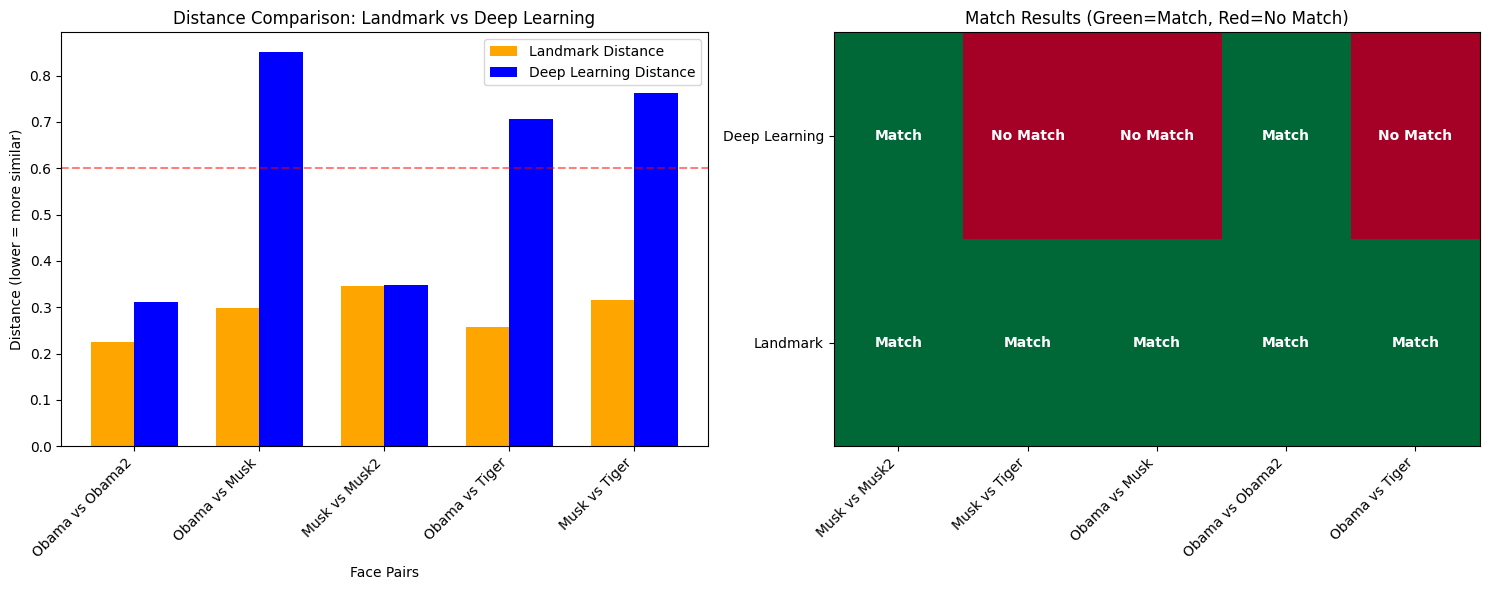



CONCLUSIONS:
------------------------------------------------------------
1. Landmark-based: Poor discrimination - matches almost everyone!
2. Deep Learning: Better discrimination - correctly identifies same/different people

WHY LANDMARK-BASED FAILS:
- Only uses geometric proportions (eye distance, face width, etc.)
- Ignores skin texture, color, fine details
- All human faces have similar proportions
- Small sample size makes all faces seem similar

DEEP LEARNING ADVANTAGES:
- Uses 128-dimensional encoding capturing subtle features
- Trained on millions of faces
- Captures texture, shadows, unique facial characteristics
- Much more robust to variations


In [36]:
# Compare both methods: Landmark-based vs Deep Learning
print("COMPARISON: Landmark-based vs Deep Learning Face Recognition\n")
print("=" * 60)

test_pairs = [
    ("Obama vs Obama2", "images/barackObama.jpg", "images/barackObama2.jpg"),
    ("Obama vs Musk", "images/barackObama.jpg", "images/elonMusk.jpg"),
    ("Musk vs Musk2", "images/elonMusk.jpg", "images/elonMusk2.jpg"),
    ("Obama vs Tiger", "images/barackObama.jpg", "images/tigerWoods.jpg"),
    ("Musk vs Tiger", "images/elonMusk.jpg", "images/tigerWoods.jpg")
]

results = []

for name, img1, img2 in test_pairs:
    # Landmark-based comparison
    sim_landmark, dist_landmark, match_landmark = compare_faces_with_landmarks(img1, img2)
    
    # Deep learning comparison
    image1 = face_recognition.load_image_file(img1)
    image2 = face_recognition.load_image_file(img2)
    
    encoding1 = face_recognition.face_encodings(image1)[0]
    encoding2 = face_recognition.face_encodings(image2)[0]
    
    match_dl = face_recognition.compare_faces([encoding1], encoding2, tolerance=0.6)[0]
    distance_dl = face_recognition.face_distance([encoding1], encoding2)[0]
    
    results.append({
        'pair': name,
        'landmark_match': match_landmark,
        'landmark_dist': dist_landmark,
        'dl_match': match_dl,
        'dl_dist': distance_dl
    })
    
    print(f"\n{name}:")
    print(f"  Landmark-based: Match={match_landmark}, Distance={dist_landmark:.3f}")
    print(f"  Deep Learning:  Match={match_dl}, Distance={distance_dl:.3f}")

# Create visualization comparing methods
import pandas as pd

df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot distances
x = range(len(df))
width = 0.35

ax1.bar([i - width/2 for i in x], df['landmark_dist'], width, label='Landmark Distance', color='orange')
ax1.bar([i + width/2 for i in x], df['dl_dist'], width, label='Deep Learning Distance', color='blue')
ax1.set_xlabel('Face Pairs')
ax1.set_ylabel('Distance (lower = more similar)')
ax1.set_title('Distance Comparison: Landmark vs Deep Learning')
ax1.set_xticks(x)
ax1.set_xticklabels(df['pair'], rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0.6, color='red', linestyle='--', alpha=0.5, label='Typical threshold')

# Plot match results
match_data = []
for _, row in df.iterrows():
    match_data.append(['Landmark', row['pair'], 1 if row['landmark_match'] else 0])
    match_data.append(['Deep Learning', row['pair'], 1 if row['dl_match'] else 0])

match_df = pd.DataFrame(match_data, columns=['Method', 'Pair', 'Match'])
pivot_df = match_df.pivot(index='Pair', columns='Method', values='Match')

ax2.imshow(pivot_df.values.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Deep Learning', 'Landmark'])
ax2.set_xticks(range(len(pivot_df)))
ax2.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax2.set_title('Match Results (Green=Match, Red=No Match)')

# Add text annotations
for i in range(len(pivot_df)):
    for j in range(2):
        text = ax2.text(i, j, 'Match' if pivot_df.values[i, j] else 'No Match',
                       ha="center", va="center", color="white", fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

print("\n\nCONCLUSIONS:")
print("-" * 60)
print("1. Landmark-based: Poor discrimination - matches almost everyone!")
print("2. Deep Learning: Better discrimination - correctly identifies same/different people")
print("\nWHY LANDMARK-BASED FAILS:")
print("- Only uses geometric proportions (eye distance, face width, etc.)")
print("- Ignores skin texture, color, fine details")
print("- All human faces have similar proportions")
print("- Small sample size makes all faces seem similar")
print("\nDEEP LEARNING ADVANTAGES:")
print("- Uses 128-dimensional encoding capturing subtle features")
print("- Trained on millions of faces")
print("- Captures texture, shadows, unique facial characteristics")
print("- Much more robust to variations")